<a href="https://colab.research.google.com/github/rushikeshnaik779/new_water/blob/main/pyspark_udfs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Below cell will help to run pyspark in colab env

In [1]:
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz



import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"


!pip install -q findspark
import findspark
findspark.init()


from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()


# data because I am reading data analysis with python and pyspark
!git clone https://github.com/jonesberg/DataAnalysisWithPythonAndPySpark-Data.git

Cloning into 'DataAnalysisWithPythonAndPySpark-Data'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Receiving objects: 100% (71/71), 828.81 MiB | 25.75 MiB/s, done.
Updating files: 100% (59/59), done.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pyspark.sql.functions as F
import pyspark.sql.types as T

spark = SparkSession.builder.getOrCreate()

In [3]:
!ls


DataAnalysisWithPythonAndPySpark-Data  spark-3.5.0-bin-hadoop3
sample_data			       spark-3.5.0-bin-hadoop3.tgz


In [4]:
elements = spark.read.csv(
    './DataAnalysisWithPythonAndPySpark-Data/elements/Periodic_Table_Of_Elements.csv',
    header = True,
    inferSchema = True,
)

elements.show(1, False)

+------------+--------+------+----------+----------------+---------------+-----------------+------+-----+-----+-----------+-------+-----+--------+---------+--------+------------+-----------------+---------------+-------+------------+------------+----------------+----------+----+------------+--------------+---------------+
|AtomicNumber|Element |Symbol|AtomicMass|NumberofNeutrons|NumberofProtons|NumberofElectrons|Period|Group|Phase|Radioactive|Natural|Metal|Nonmetal|Metalloid|Type    |AtomicRadius|Electronegativity|FirstIonization|Density|MeltingPoint|BoilingPoint|NumberOfIsotopes|Discoverer|Year|SpecificHeat|NumberofShells|NumberofValence|
+------------+--------+------+----------+----------------+---------------+-----------------+------+-----+-----+-----------+-------+-----+--------+---------+--------+------------+-----------------+---------------+-------+------------+------------+----------------+----------+----+------------+--------------+---------------+
|1           |Hydrogen|H    

In [5]:
elements.where(F.col('phase')=='liq').groupby('period').count().show()

+------+-----+
|period|count|
+------+-----+
|     6|    1|
|     4|    1|
+------+-----+



In [6]:
try :
    spark.sql(
        "select period, count(*) from elements"
        "where phase='liq' group by period"
    ).show(5)

except AnalysisException as e:
    print(e)




[PARSE_SYNTAX_ERROR] Syntax error at or near '='.(line 1, pos 48)

== SQL ==
select period, count(*) from elementswhere phase='liq' group by period
------------------------------------------------^^^



In [7]:
elements.createOrReplaceTempView("elements")

spark.sql(
        "select period, count(*) from elements where phase='liq' group by period"
    ).show(5)

+------+--------+
|period|count(1)|
+------+--------+
|     6|       1|
|     4|       1|
+------+--------+



In [8]:
# createGlobalTempView()
# createOrReplaceGlobalTempView()
# createOrReplaceTempView()
# createTempView()

spark.catalog.listTables()

[Table(name='elements', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

In [9]:
spark.catalog.dropTempView("elements")
spark.catalog.listTables()

[]

In [10]:
print('8 Extending pyspark with python : RDD and UDFs')



8 Extending pyspark with python : RDD and UDFs


In [11]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

collection = [
    1,
    "two",
    3.0,
    ("four", 4),
    {"five": 5}
] # my collection is a lisat of an integer and other dtypes

print(collection)

# creating a spark context

sc = spark.sparkContext

collection_rdd = sc.parallelize(collection)

print(collection_rdd)


[1, 'two', 3.0, ('four', 4), {'five': 5}]
ParallelCollectionRDD[42] at readRDDFromFile at PythonRDD.scala:289


In [12]:
# Manipulating Data the RDD way : map(), filter(), & reduce()


# mapping a simple function, add_one() to each element

from py4j.protocol import Py4JJavaError

def add_one(value):
    return value + 1

collection_rdd = collection_rdd.map(add_one)


try:
    print(collection_rdd.collect())

except Py4JJavaError as e:
    pass

In [13]:
collection_rdd = sc.parallelize(collection)

def safer_add_one(value):
    try:
        return value + 1

    except TypeError:
        return value


collection_rdd = collection_rdd.map(safer_add_one)

print(collection_rdd.collect())

[2, 'two', 4.0, ('four', 4), {'five': 5}]


In [14]:
collection_rdd_filtered = collection_rdd.filter(
    lambda elem: isinstance(elem, (float, int))
)

print(collection_rdd_filtered.collect())

[2, 4.0]


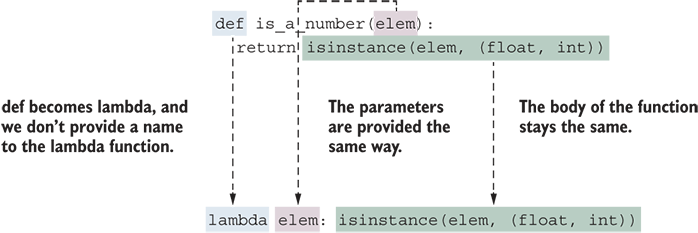

In [15]:
# applying add function via reduce

from operator import add

collection_rdd = sc.parallelize([100]*10)
print(collection_rdd.reduce(add))

1000


In [16]:
# uncovering the rdd from within a dataframe using the rdd attributes

df = spark.createDataFrame(
    [
        [1], [2], [3]
    ],
    schema=["column"]
)

print(df.rdd)

MapPartitionsRDD[57] at javaToPython at NativeMethodAccessorImpl.java:0


In [17]:
print(df.rdd.collect())

[Row(column=1), Row(column=2), Row(column=3)]


In [18]:
df.show()

+------+
|column|
+------+
|     1|
|     2|
|     3|
+------+



In [19]:
df.count()

3

## Using Python to extend PySpark via UDFs

In [20]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [21]:
fractions = [[x, y] for x in range(100) for y in range(1, 100)]


In [22]:
frac_df = spark.createDataFrame(fractions, ["numerator", "denominator"])

frac_df.show(1, False)

+---------+-----------+
|numerator|denominator|
+---------+-----------+
|0        |1          |
+---------+-----------+
only showing top 1 row



In [23]:
frac_df = frac_df.select(
    F.array(F.col("numerator"), F.col("denominator")).alias(
        "fraction"
    ),
)

frac_df.show(5, False)

+--------+
|fraction|
+--------+
|[0, 1]  |
|[0, 2]  |
|[0, 3]  |
|[0, 4]  |
|[0, 5]  |
+--------+
only showing top 5 rows



My blueprint when creating a function destined to become a Python UDF is as follows:

1. Create and document the function.
2. Make sure the input and output types are compatible.
3. Test the function.

In [24]:
from fractions import Fraction
from typing import Tuple, Optional

Frac = Tuple[int, int]

def py_reduce_fraction(frac: Frac) -> Optional[Frac]:
    """
    Reduce a fraction represented as a 2-tuple of integers.
    """
    num, denom = frac
    if denom:
        answer = Fraction(num, denom)
        return answer.numerator, answer.denominator

    return None


assert py_reduce_fraction((3, 6)) == (1, 2)
assert py_reduce_fraction((1, 0)) is None




In [25]:
print(py_reduce_fraction((6, 2)))

(3, 1)


In [26]:
def py_fraction_to_float(frac: Frac) -> Optional[float]:
    """Transforms a fraction represented as a 2-tuple of integers into a float"""

    num, denom = frac
    if denom:
        return num/denom

    return None


assert py_fraction_to_float((2, 8)) == 0.25

assert py_fraction_to_float((10, 0)) is None

In [27]:
print(py_fraction_to_float((22, 7)))

3.142857142857143


# From Python Function to UDFs using udf()


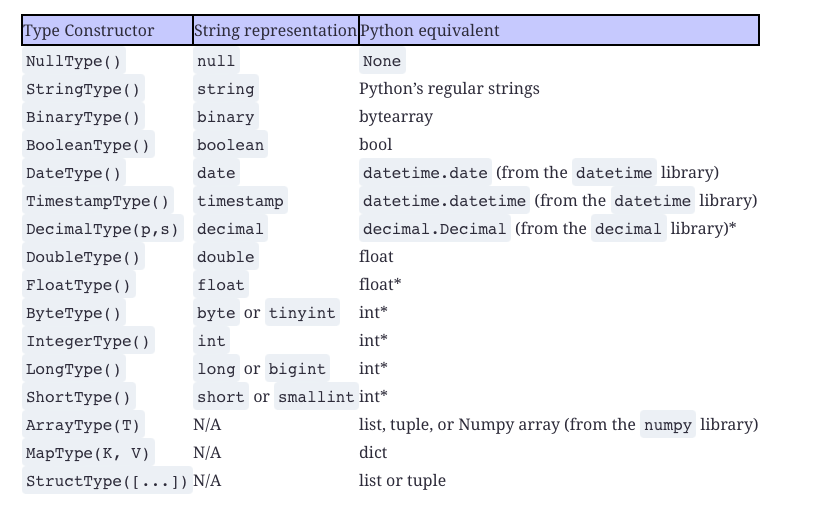

In [28]:
# pyspark.sql.functions
# the function you want to promote
# return type of the generated udf

# let's create udf by using explicit UDF function

SparkFrac = T.ArrayType(T.LongType())
reduce_fraction = F.udf(py_reduce_fraction, SparkFrac)

frac_df = frac_df.withColumn(
    "reduce_fraction", reduce_fraction(F.col("fraction"))
)


frac_df.show(5, False)



+--------+---------------+
|fraction|reduce_fraction|
+--------+---------------+
|[0, 1]  |[0, 1]         |
|[0, 2]  |[0, 1]         |
|[0, 3]  |[0, 1]         |
|[0, 4]  |[0, 1]         |
|[0, 5]  |[0, 1]         |
+--------+---------------+
only showing top 5 rows



In [29]:
# listing udf using decorator

@F.udf(T.DoubleType())
def fraction_to_float(frac:Frac) -> Optional[float]:
    """
    Transforms a fraction represented as a 2-tuple of integers into a float
    """
    num, denom = frac
    if denom:
        return num / denom

    return None



# let's call the udf function

frac_df = frac_df.withColumn(
    "fraction_float", fraction_to_float(F.col("reduce_fraction"))
)

frac_df.select("reduce_fraction", "fraction_float").distinct().show(
    5, False
)


+---------------+-------------------+
|reduce_fraction|fraction_float     |
+---------------+-------------------+
|[3, 50]        |0.06               |
|[3, 67]        |0.04477611940298507|
|[7, 76]        |0.09210526315789473|
|[9, 23]        |0.391304347826087  |
|[9, 25]        |0.36               |
+---------------+-------------------+
only showing top 5 rows



In [30]:
# prompt: check PySpark version

print(SparkSession.builder.getOrCreate().version)


3.5.0


In [31]:
!pip install pandas scikit-learn pyarrow

Pyspark provides three types of series udfs.
* Ther series to series is the simplest. It takes columns objects as input converts them to pandas Series objects and returns a series object that gets promoted back to pyspark column object

* The iterator of series to iterator of series. Differs in the sense that the columnb objects get batched into batches and then feb as iterator objects, It takes a single column as object as input and return a single column. It Provides performance improvements, especially when the UDF need to initialize an expensice state before working on the data

* The iterator of multiple series to iterator of seres is a columbination of the previous series udfs and can take multiuple columns as input like the series to series udf, yet preserves the iterator pattern from the iterator of series to Iterator of series




In [32]:
from functools import reduce
import pyspark.sql.functions as F



gsod = (
    reduce(
        lambda x, y: x.unionByName(y, allowMissingColumns=True),
        [
            spark.read.parquet(f"/content/DataAnalysisWithPythonAndPySpark-Data/gsod_noaa/gsod{year}.parquet")
            for year in range(2010, 2021)

        ],
    )
    .dropna(subset = ['year', 'mo', 'da', 'temp'])
    .where(F.col("temp") != 9999.9)
    .drop("date")
)

gsod.show(1, False)

+------+-----+----+---+---+----+----------+----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+-----+---------+-----+---+------------+----------------+----+-------+--------------------+
|stn   |wban |year|mo |da |temp|count_temp|dewp|count_dewp|slp   |count_slp|stp   |count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd|gust |max |flag_max|min |flag_min|prcp |flag_prcp|sndp |fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+------+-----+----+---+---+----+----------+----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+-----+---------+-----+---+------------+----------------+----+-------+--------------------+
|359250|99999|2010|03 |16 |38.4|6         |35.9|5         |1003.5|6        |9999.9|0        |999.9|0          |5.8 |6         |9.7  |999.9|40.1|NULL    |36.5|NULL    |99.99|NULL     |999.9|0  |1           |0               |0  

In [33]:
gsod.printSchema()

root
 |-- stn: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- year: string (nullable = true)
 |-- mo: string (nullable = true)
 |-- da: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: long (nullable = true)
 |-- dewp: double (nullable = true)
 |-- count_dewp: long (nullable = true)
 |-- slp: double (nullable = true)
 |-- count_slp: long (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: long (nullable = true)
 |-- visib: double (nullable = true)
 |-- count_visib: long (nullable = true)
 |-- wdsp: string (nullable = true)
 |-- count_wdsp: string (nullable = true)
 |-- mxpsd: string (nullable = true)
 |-- gust: double (nullable = true)
 |-- max: double (nullable = true)
 |-- flag_max: string (nullable = true)
 |-- min: double (nullable = true)
 |-- flag_min: string (nullable = true)
 |-- prcp: double (nullable = true)
 |-- flag_prcp: string (nullable = true)
 |-- sndp: double (nullable = true)
 |-- fog: string (nullable =

In [34]:
import pandas as pd
import pyspark.sql.types as T


@F.pandas_udf(T.DoubleType())
def f_to_c(degrees: pd.Series) -> pd.Series:
    """
    Transforms Farhenheit to Celsius
    """
    return (degrees - 32) * 5/9





In [35]:
gsod = gsod.withColumn("temp_c", f_to_c(F.col("temp")))


In [36]:
gsod

DataFrame[stn: string, wban: string, year: string, mo: string, da: string, temp: double, count_temp: bigint, dewp: double, count_dewp: bigint, slp: double, count_slp: bigint, stp: double, count_stp: bigint, visib: double, count_visib: bigint, wdsp: string, count_wdsp: string, mxpsd: string, gust: double, max: double, flag_max: string, min: double, flag_min: string, prcp: double, flag_prcp: string, sndp: double, fog: string, rain_drizzle: string, snow_ice_pellets: string, hail: string, thunder: string, tornado_funnel_cloud: string, temp_c: double]

In [37]:
gsod.select("temp", "temp_c").distinct().show(5)

+----+-------------------+
|temp|             temp_c|
+----+-------------------+
|29.6|-1.3333333333333326|
|37.2| 2.8888888888888906|
|53.5| 11.944444444444445|
|70.4| 21.333333333333336|
|24.7| -4.055555555555555|
+----+-------------------+
only showing top 5 rows



In [38]:
gsod.select("temp", "temp_c").printSchema()

root
 |-- temp: double (nullable = true)
 |-- temp_c: double (nullable = true)



In [39]:
# Scalar UDF + cold start = Iterator of Series UDF

In [40]:
from time import sleep
from typing import Iterator


@F.pandas_udf(T.DoubleType())
def f_to_c2(degrees: Iterator[pd.Series]) -> Iterator[pd.Series]:
    """
    Transforms Farhenheit to Celsius
    """
    sleep(5)
    for batch in degrees:
        yield(batch - 32) * 5/9


In [41]:
gsod.select(
    "temp", f_to_c2(F.col("temp")).alias("temp_c")
).distinct().show(5)


+----+-------------------+
|temp|             temp_c|
+----+-------------------+
|29.6|-1.3333333333333326|
|37.2| 2.8888888888888906|
|53.5| 11.944444444444445|
|70.4| 21.333333333333336|
|24.7| -4.055555555555555|
+----+-------------------+
only showing top 5 rows



In [42]:
from typing import Tuple

@F.pandas_udf(T.DateType())
def create_date(
        year_mo_da: Iterator[Tuple[pd.Series, pd.Series, pd.Series]]
) -> Iterator[pd.Series]:
    """
    Merges three cols (representing Y-M-D of a date ) into a Date col.
    """
    for year, mo, da in year_mo_da:
        yield pd.to_datetime(
            pd.DataFrame(dict(year = year, month=mo, day=da))
        )




gsod.select(
    "year", "mo", "da",
    create_date(
        F.col("year"),
        F.col("mo"),
        F.col("da")
    ).alias("date")
).distinct().show(2)

+----+---+---+----------+
|year| mo| da|      date|
+----+---+---+----------+
|2010| 08| 31|2010-08-31|
|2010| 12| 20|2010-12-20|
+----+---+---+----------+
only showing top 2 rows



In [43]:
# pd.to_datetime(pd.DataFrame(dict(year = 2010,
#                   month = 8,
#                   day = 31),
#               index = ['2010-08-31']))

# 9.2 UDFs on grouped data: Aggregate and apply

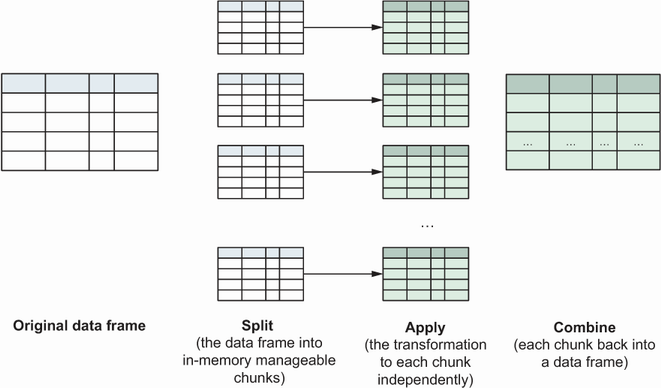

### UDFs on grouped data : Aggregate and apply

* Group aggregate UDFs
* Group map UDFs

what it does in a nutshell is:
1. Split your data set into logical batches (using groupby())
2. Apply a function to each batch independently
3. Combine the batches into a unified data set

In [44]:
# group aggregate udfs
from sklearn.linear_model import LinearRegression

@F.pandas_udf(T.DoubleType())
def rate_of_change_temperature(
        day: pd.Series,
        temp: pd.Series
    )-> float:
    """
    Returns the slope of the daily temperature for a given period of a time
    """
    return (
        LinearRegression()
        .fit(X=day.astype(int).values.reshape(-1, 1), y=temp)
        .coef_[0]
        )



In [46]:
result = gsod.groupby("stn", "year", "mo").agg(
    rate_of_change_temperature(gsod["da"], gsod["temp"]).alias(
        "rt_chg_temp"
    )
)

In [47]:
result.show()

+------+----+---+--------------------+
|   stn|year| mo|         rt_chg_temp|
+------+----+---+--------------------+
|007032|2013| 01| -0.2795031055900618|
|008268|2010| 07| -2.1999999999999877|
|008400|2010| 02|  1.7828571428571436|
|008400|2010| 08|  0.8514508067970873|
|008401|2011| 03|  0.7514516129032257|
|008401|2011| 04|  0.7189321468298108|
|008401|2011| 09|  -0.305939933259177|
|008401|2011| 11|-0.30429365962180205|
|008401|2012| 06|-0.02091212458286...|
|008402|2010| 09| -0.4415127919911011|
|008402|2011| 06| 0.07127919911012245|
|008403|2012| 01|-0.07081307998232432|
|008405|2010| 09| -0.4504783092324805|
|008405|2011| 09|-0.37739710789766434|
|008405|2012| 08|0.058608058608058525|
|008406|2011| 11| -0.2953948832035597|
|008407|2010| 04|  0.3175528364849835|
|008407|2011| 02| -0.7043956043956047|
|008411|2010| 05|  0.4031854838709678|
|008411|2011| 03| 0.26262096774193555|
+------+----+---+--------------------+
only showing top 20 rows



In [50]:
# group map udf

def scale_temperature(temp_by_day: pd.DataFrame)-> pd.DataFrame:
    """ Returns a simple normalization of the temperature for a site.
        If the temperature is constant for the whole window, defaults to 0.5
    """
    temp = temp_by_day.temp
    answer = temp_by_day[["stn", "year", "mo", "da", "temp"]]

    if temp.min() == temp.max():
        return answer.assign(temp_norm=0.5)


    return answer.assign(
        temp_norm = (temp - temp.min())/(temp.max() - temp.min())

        )

In [51]:
gsod_map = gsod.groupby("stn", "year", "mo").applyInPandas(
    scale_temperature,
    schema = (
        "stn string, year string, mo string, "
        "da string, temp double, temp_norm double"
    ),
)

gsod_map.show(5, False)

+------+----+---+---+----+------------------+
|stn   |year|mo |da |temp|temp_norm         |
+------+----+---+---+----+------------------+
|008268|2010|07 |21 |89.6|1.0               |
|008268|2010|07 |22 |87.4|0.0               |
|008401|2011|11 |24 |61.3|0.52              |
|008401|2011|11 |05 |66.0|0.7080000000000001|
|008401|2011|11 |01 |68.2|0.7960000000000003|
+------+----+---+---+----+------------------+
only showing top 5 rows



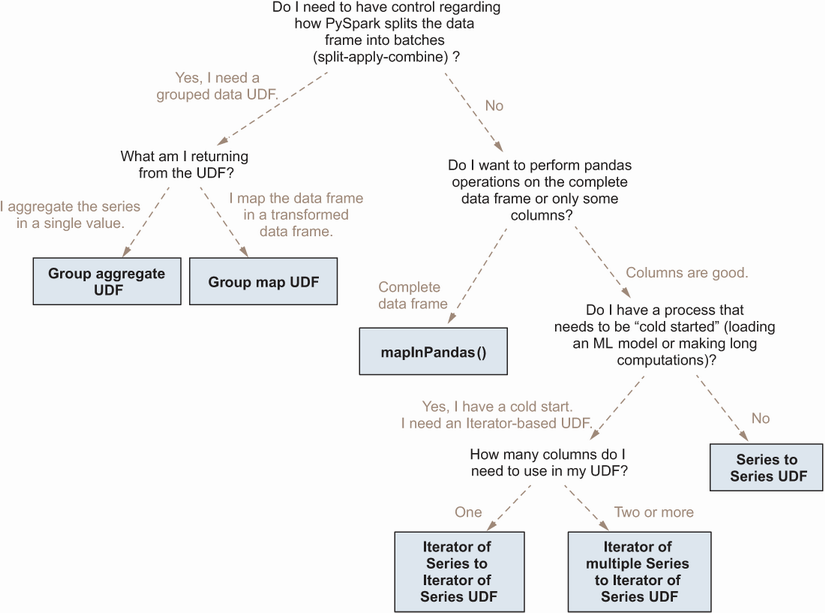